In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

# How to convert: ipython nbconvert --to slides presentation.ipynb --post serve

# `astroplan`

## Plan for everything but the clouds ☁️

### Brett Morris

with Jazmin Berlanga Medina, Christoph Deil, Eric Jeschke, Adrian Price-Whelan, Erik Tollerud

## Getting started

```bash
pip install astropy astroplan
echo "Optionally:"
pip install wcsaxes astroquery
```

## Outline

* Background: `astropy`
* `astroplan` basics


<img src="https://raw.githubusercontent.com/astropy/astropy-logo/master/generated/astropy_powered.png" width="300">

## Background

* Open source Python astronomical toolkit
* Generic and powerful
* `astropy`-affiliated packages assemble more specific functionality

#### `astropy`: RA/Dec -> Alt/Az

In [21]:
# Altitude-azimuth frame: 
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.units as u
from astropy.time import Time

# Specify location of Apache Point Observatory with astropy.coordinates.EarthLocation
apache_point = EarthLocation.from_geodetic(-105.82*u.deg, 32.78*u.deg, 2798*u.m)

# Specify star's location with astropy.coordinates.SkyCoord
vega_icrs = SkyCoord(ra=279.235416*u.deg, dec=38.78516*u.deg)

# Initialize an altitude/azimuth frame at the present time
time = Time.now()
altaz_frame = AltAz(obstime=time, location=apache_point)

# Get Vega's alt/az position now
vega_altaz = vega_icrs.transform_to(altaz_frame)
print("Vega (altitude, azimuth) [deg, deg] at {}:\n\t({}, {})"
      .format(time, vega_altaz.alt.degree, vega_altaz.az.degree))

Vega (altitude, azimuth) [deg, deg] at 2016-02-09 18:00:59.186707:
	(69.4365111185583, 293.9051155643265)


#### `astropy`: Get coordinates of the Sun

In [3]:
# Where is the sun right now?
from astropy.coordinates import get_sun

sun = get_sun(time)
print(sun)

<SkyCoord (GCRS: obstime=2016-02-09 18:00:45.558567, obsgeoloc=[ 0.  0.  0.] m, obsgeovel=[ 0.  0.  0.] m / s): (ra, dec, distance) in (deg, deg, AU)
    (323.58130405, -14.43302781, 0.986627)>


## `astroplan` v0.1

* Open source in Python
* `astropy` powered
* Get (alt/az) positions of targets at any time, from any observatory
* Can I observe these targets given some constraints (airmass, moon separation, etc.)?

## `astroplan` basics

* `astroplan.Observer`: contains information about an observer's location, environment on the Earth

In [4]:
from astroplan import Observer

# Construct an astroplan.Observer at Apache Point Observatory
apache_point = Observer.at_site("Apache Point")
apache_point = Observer.at_site("APO")   # also works

print(apache_point.location.to_geodetic())

(<Longitude -105.82000000000002 deg>, <Latitude 32.78000000000001 deg>, <Quantity 2797.9999999996007 m>)


## `astroplan` basics

* `astroplan.FixedTarget`: contains information about celestial objects with no (slow) proper motion

In [5]:
from astroplan import FixedTarget

# Construct an astroplan.FixedTarget for Vega
vega = FixedTarget.from_name("Vega")  # (with internet access)

# # (without internet access)
# vega_icrs = SkyCoord(ra=279.235416*u.deg, dec=38.78516*u.deg)
# vega = FixedTarget(coord=vega_icrs, name="Vega")

vega_altaz = apache_point.altaz(time, vega)

print("Vega (altitude, azimuth) [deg, deg] at {}:\n\t({}, {})"
      .format(time, vega_altaz.alt.degree, vega_altaz.az.degree))

Vega (altitude, azimuth) [deg, deg] at 2016-02-09 18:00:45.558567:
	(69.47999708651103, 293.92168741017167)


# Convenience methods

Is it night at this observatory at `time`?

|     Question     |     Answer    | 
|------------------|---------------|
| Is it nighttime? | observer.is_night(time) | 
| Is Vega up?      | observer.target_is_up(time, vega) | 
| What is the LST? | observer.local_sidereal_time(time) |
| Hour angle of Vega? | observer.target_hour_angle(time, vega) |

In [6]:
apache_point.is_night(time)

False

Is Vega above the horizon at `time`?

In [7]:
apache_point.target_is_up(time, vega)

True

Make your own TUI window:

In [8]:
# Local Sidereal time
apache_point.local_sidereal_time(time)

<Longitude 20.24271852745287 hourangle>

In [9]:
# Hour angle
apache_point.target_hour_angle(time, vega)

<Longitude 1.6270695416528653 hourangle>

In [10]:
# Parallactic angle
apache_point.parallactic_angle(time, vega)

<Angle -1.406679290562635 rad>

## Rise/set times

Next sunset

In [11]:
sunset = apache_point.sun_set_time(time, which='next')

print("{0.jd} = {0.iso}".format(sunset))

2457428.5303427037 = 2016-02-10 00:43:41.610


Next rise of Vega

In [12]:
vega_rise = apache_point.target_rise_time(time, vega, which='next')

print(vega_rise.iso)

2016-02-10 08:16:34.025


Next astronomical (-18 deg) twilight

In [13]:
astronomical_twilight = apache_point.twilight_evening_astronomical(time, which='next')

print(astronomical_twilight.iso)

2016-02-10 02:11:13.449


What is that time in local Seattle time (PST)?

In [28]:
# Specify your time zone with `pytz`
import pytz

my_timezone = pytz.timezone('US/Pacific')

astronomical_twilight.to_datetime(my_timezone)

datetime.datetime(2016, 2, 9, 18, 11, 13, 449428, tzinfo=<DstTzInfo 'US/Pacific' PST-1 day, 16:00:00 STD>)

# Constraints

Can I observe target(s) given:

* **Time**
  * of year
  * of night
  * at "night"

* **Telescope**: 
  * Altitude constraints, i.e. 15-80$^\circ$ altitude
  * Location on Earth

* **Moon** separation, illumination

## Constraints example

Let's read in a list of RA/Dec of our targets:

In [14]:
%%writefile targets.txt
# name ra_degrees dec_degrees
Polaris 37.95456067 89.26410897
Vega 279.234734787 38.783688956
Albireo 292.68033548 27.959680072
Algol 47.042218553 40.955646675
Rigel 78.634467067 -8.201638365
Regulus 152.092962438 11.967208776

Overwriting targets.txt


Read in target file to a list of `astroplan.FixedTarget` objects:

In [15]:
# Read in the table of targets
from astropy.table import Table

target_table = Table.read('targets.txt', format='ascii')

# Create astroplan.FixedTarget objects for each one in the table
from astropy.coordinates import SkyCoord
import astropy.units as u

from astroplan import FixedTarget

targets = [FixedTarget(coord=SkyCoord(ra=ra*u.deg, dec=dec*u.deg), name=name)
           for name, ra, dec in target_table]

Initialize `astroplan.Observer`, observing time window:

In [16]:
from astroplan import Observer
from astropy.time import Time

subaru = Observer.at_site("Subaru")
time_range = Time(["2015-08-01 06:00", "2015-08-01 12:00"])

Define and compute constraints:

In [17]:
from astroplan import (AltitudeConstraint, AirmassConstraint,
                       AtNightConstraint)

# Define constraints:
constraints = [AltitudeConstraint(10*u.deg, 80*u.deg),
               AirmassConstraint(5), AtNightConstraint.twilight_civil()]

In [18]:
from astroplan import is_observable, is_always_observable

# Compute: are targets *ever* observable in the time range?
ever_observable = is_observable(constraints, subaru, targets, time_range=time_range)

# Compute: are targets *always* observable in the time range?
always_observable = is_always_observable(constraints, subaru, targets, time_range=time_range)

In [19]:
from astroplan import observability_table

table = observability_table(constraints, subaru, targets, time_range=time_range)

print(table)

target name ever observable always observable fraction of time observable
----------- --------------- ----------------- ---------------------------
    Polaris            True              True                         1.0
       Vega            True              True                         1.0
    Albireo            True             False              0.833333333333
      Algol            True             False              0.166666666667
      Rigel           False             False                         0.0
    Regulus           False             False                         0.0


### Plot celestial sphere positions

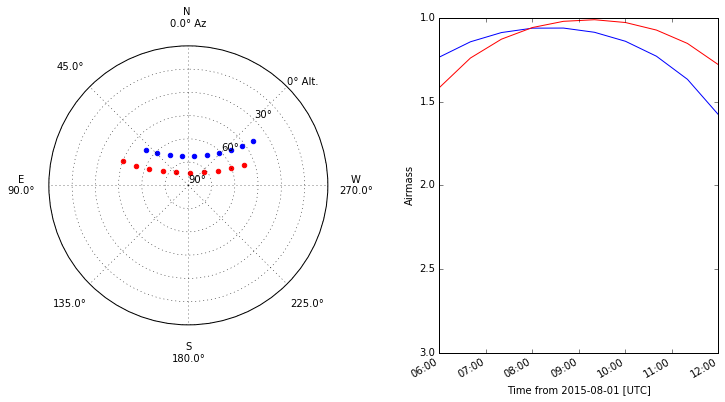

In [20]:
%matplotlib inline
from astroplan.plots import plot_sky, plot_airmass

import numpy as np
import matplotlib.pyplot as plt

plot_times = time_range[0] + np.linspace(0, 1, 10)*(time_range[1] - time_range[0])

fig = plt.figure(figsize=(12, 6))
ax0 = fig.add_subplot(121, projection='polar')
ax1 = fig.add_subplot(122)

# Plot Vega track
plot_sky(targets[1], subaru, plot_times, ax=ax0,
         style_kwargs=dict(color='b', label='Vega'))
plot_airmass(targets[1], subaru, plot_times, ax=ax1,
             style_kwargs=dict(color='b'))

# Plot Albireo track
plot_sky(targets[2], subaru, plot_times,  ax=ax0,
         style_kwargs=dict(color='r', label='Albireo'))
plot_airmass(targets[2], subaru, plot_times, ax=ax1,
             style_kwargs=dict(color='r'))

fig.subplots_adjust(wspace=0.4);

### Plot finder charts

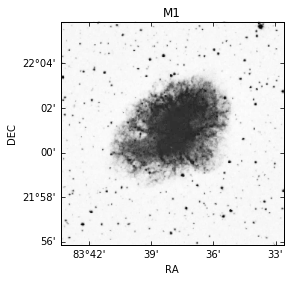

In [26]:
# This method requires astroquery, wcsaxes
from astroplan.plots import plot_finder_image

m1 = FixedTarget.from_name('M1')

plot_finder_image(m1, survey='DSS');

## Google Summer of Code

* Google supports Python Software Foundation supports `astropy`
* `astropy` suggests projects and takes proposals for novel ones
* Knowledgable mentors guide students through project

<img src="https://developers.google.com/open-source/gsoc/images/gsoc2015-300x270.jpg" width="200">

## Acknowledgements

* Python Software Foundation
* Google Summer of Code
* Co-contributor/conspirator: Jazmin Berlanga Medina
* Mentors: Christoph Deil, Eric Jeschke, Adrian Price-Whelan, Erik Tollerud


<img src="https://www.python.org/static/community_logos/python-logo-master-v3-TM.png" width="200">
